# Implementing Spin Dynamics with longitudinal fluctuations

cf. [this paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.054416)

In [1]:
from pyiron import Project
import numpy as np
import matplotlib.pylab as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
a_0 = 2.83
n_repeat = 5
J = 0.1
hbar = 6.5821e-1
delta_t = 0.001
gamma_s = 8e-3
A = -0.1
B = 0.01
temperature = 10000
structure = Project('.').create_structure('Fe', 'bcc', a_0).repeat(n_repeat)

In [3]:
def get_initial_magnetic_moments(tilt=True, random=False):
    magmoms = np.ones(len(structure))[:,None]*np.array([0, 0, 1])[None,:]
    if tilt:
        magmoms[0] = np.array([1, 0, 0])
    if random:
        magmoms = np.random.random((len(structure), 3))-0.5
    magmoms /= np.linalg.norm(magmoms, axis=-1)[:,None]
    return magmoms

In [4]:
class SD:
    def __init__(
        self,
        J=J,
        A=A,
        B=B,
        structure=structure,
        hbar=hbar,
        gamma_s=gamma_s,
        temperature=temperature,
        delta_t=delta_t,
    ):
        self.A = A
        self.B = B
        self.J = J
        self.hbar = hbar
        self.gamma_s = gamma_s
        kBT = 8.617e-5*temperature
        self.mu_s = 2*gamma_s*hbar*kBT/delta_t
        self.mu_s = np.sqrt(self.mu_s)
        self.structure = structure
        neigh = structure.get_neighbors(num_neighbors=8)
        self.shell_matrix = neigh.get_shell_matrix()[0]*self.J
        self.hbar = hbar
        self.delta_t = delta_t
        self.original = False
        self.landau_heisenberg = False

    def get_energy(self, magmoms):
        heisenberg = -0.5*np.einsum('ij,ij->', magmoms, (self.shell_matrix @ magmoms), optimize=True)
        if not self.landau_heisenberg:
            return heisenberg
        m_norm = np.linalg.norm(magmoms, axis=-1)
        return heisenberg+self.A*np.sum(m_norm**2)+self.B*np.sum(m_norm**4)

    def get_H(self, magmoms):
        heisenberg = self.shell_matrix @ magmoms
        if not self.landau_heisenberg:
            return heisenberg
        m_norm = np.linalg.norm(magmoms, axis=-1)
        return heisenberg-2*self.A*magmoms-4*self.B*magmoms*(m_norm**2)[:,None]

    def get_h(self):
        return self.mu_s*np.random.randn(len(self.structure), 3)

    def dSdt_det_old(self, magmoms):
        first_term = np.cross(magmoms, self.get_H(magmoms))
        second_term = -self.gamma_s*np.cross(magmoms, np.cross(magmoms, self.get_H(magmoms)))
        return (first_term+second_term)/self.hbar

    def dSdt_sto_old(self, magmoms):
        return np.cross(magmoms, self.get_h())/self.hbar
    
    def dSdt_old(self, magmoms):
        return self.dSdt_det_old(magmoms)+self.dSdt_sto_old(magmoms)

    def dSdt_det(self, magmoms):
        if self.original:
            return self.dSdt_det_old(magmoms)
        return np.cross(magmoms, self.get_H(magmoms))/self.hbar+self.gamma_s*self.get_H(magmoms)

    def dSdt_sto(self, magmoms):
        if self.original:
            return self.dSdt_sto_old(magmoms)
        return self.gamma_s*self.get_h()

    def dSdt(self, magmoms):
        if self.original:
            return self.dSdt_old(magmoms)
        return self.dSdt_det(magmoms)+self.dSdt_sto(magmoms)

# Spin dynamics without longitudinal contribution

In [5]:
magmoms = get_initial_magnetic_moments(tilt=True)
energy_list = []
temperature = 1000
sd = SD(temperature=temperature)
sd.original = True
for i in np.arange(100000):
    magmoms += delta_t*sd.dSdt_det(magmoms)
    magmoms /= np.linalg.norm(magmoms, axis=-1)[:,np.newaxis]
    magmoms += delta_t*sd.dSdt_sto(magmoms)
    magmoms /= np.linalg.norm(magmoms, axis=-1)[:,np.newaxis]
    energy_list.append(sd.get_energy(magmoms))

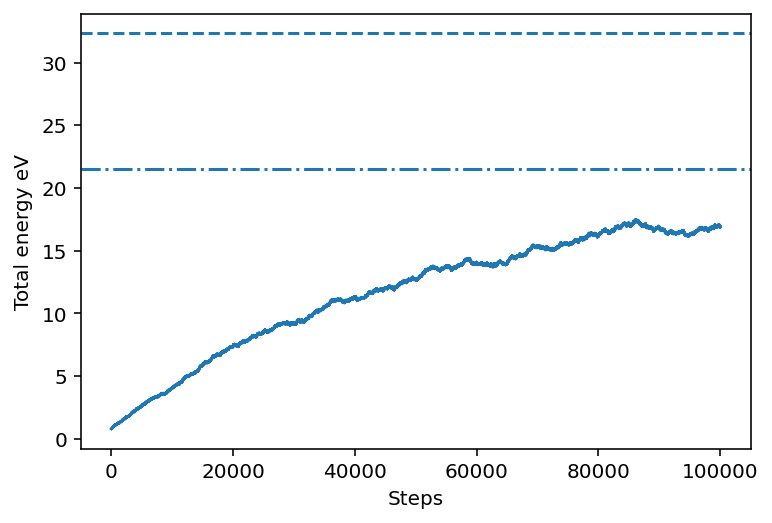

In [6]:
# plt.yscale('log')
plt.xlabel('Steps')
plt.ylabel('Total energy eV')
N = len(structure)
kBT = 8.617e-5*temperature
plt.axhline(3/2*N*kBT, linestyle='--')
plt.axhline(N*kBT, linestyle='-.')
plt.plot(np.array(energy_list)-sd.get_energy(get_initial_magnetic_moments(tilt=False)))

# Spin Dynamics with longitudinal contribution

In [7]:
m_std_list = []
m_ave_list = []
orient_std_list = []
magmoms = get_initial_magnetic_moments(tilt=False)*5.1
energy_list = []
temperature = 100000
sd = SD(temperature=temperature)
sd.original = False
sd.landau_heisenberg = True
for i in np.arange(10000):
    magmoms += delta_t*sd.dSdt_det(magmoms)
    magmoms += delta_t*sd.dSdt_sto(magmoms)
    energy_list.append(sd.get_energy(magmoms))
    m_std_list.append(np.std(np.linalg.norm(magmoms, axis=-1)))
    m_ave_list.append(np.mean(np.linalg.norm(magmoms, axis=-1)))
    orient_std_list.append(np.std(np.arccos(magmoms[:,2]/np.linalg.norm(magmoms, axis=-1))))

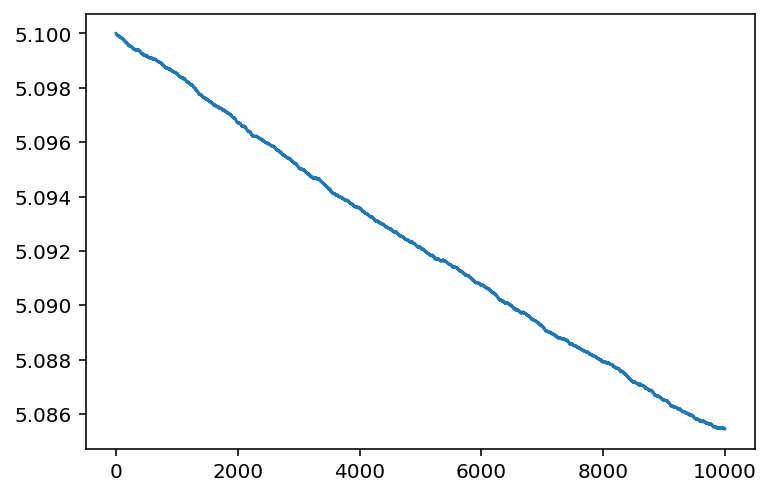

In [8]:
plt.plot(m_ave_list)

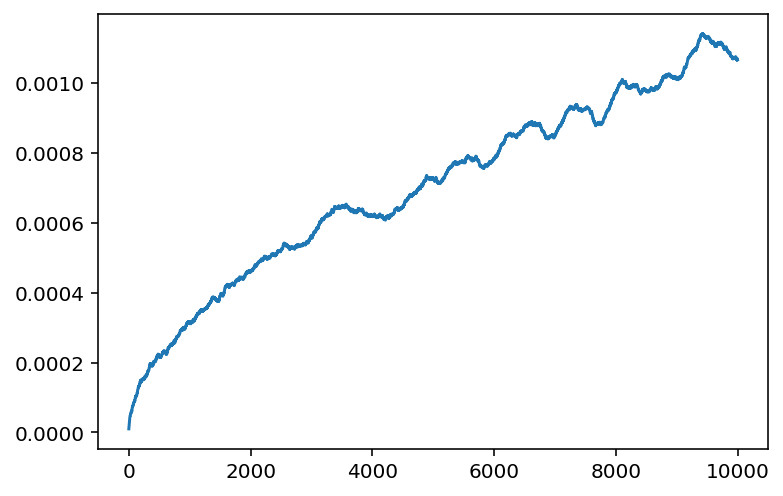

In [9]:
plt.plot(orient_std_list)

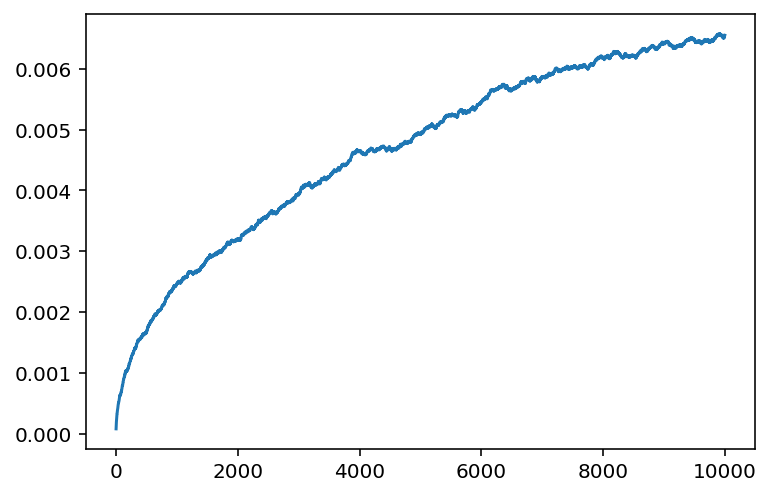

In [10]:
plt.plot(m_std_list)

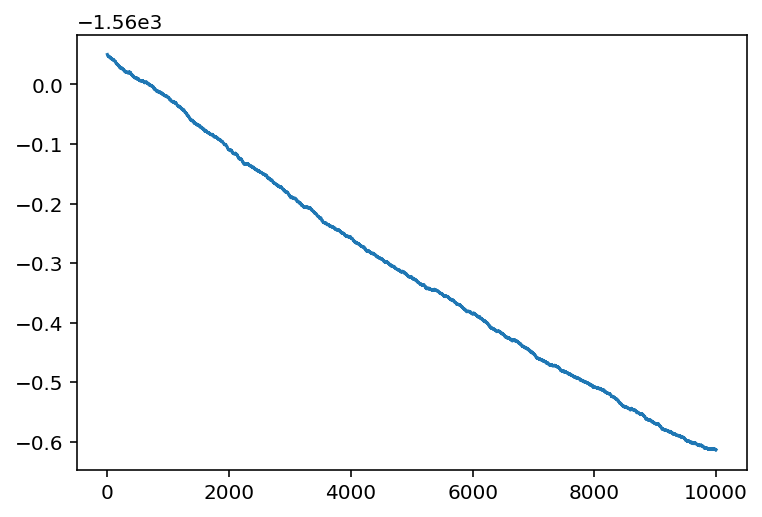

In [11]:
plt.plot(energy_list);

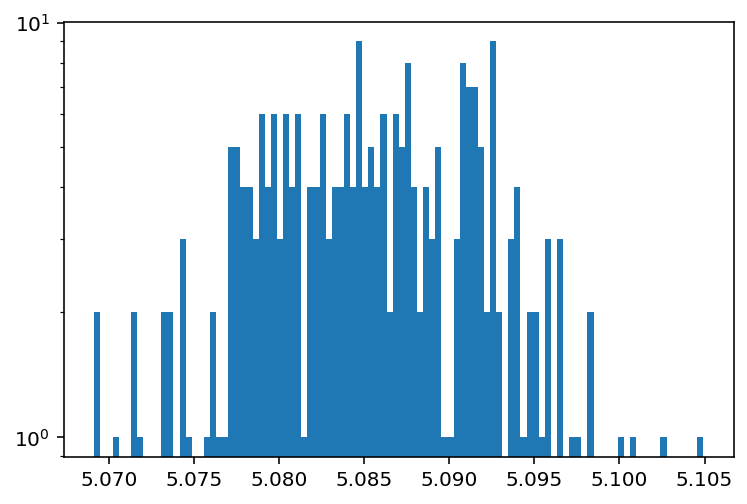

In [15]:
plt.yscale('log')
plt.hist(np.linalg.norm(magmoms, axis=-1), bins=100);

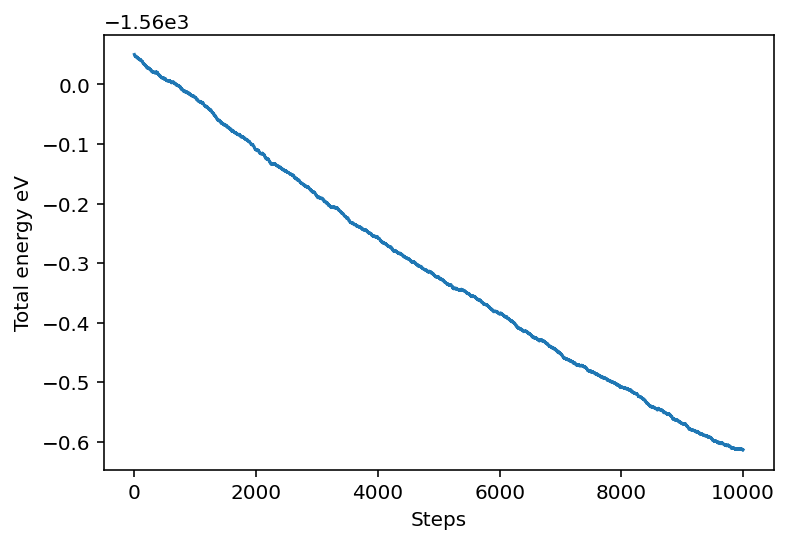

In [14]:
# plt.yscale('log')
plt.xlabel('Steps')
plt.ylabel('Total energy eV')
N = len(structure)
kBT = 8.617e-5*temperature
# plt.axhline(3/2*N*kBT, linestyle='--')
# plt.axhline(N*kBT, linestyle='-.')
plt.plot(np.array(energy_list));